<a href="https://colab.research.google.com/github/amamra-abdenour/Autoencoders-and-decoders-using-keras-and-tensorflow/blob/master/DeepLearning_DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np
img_shape = (28,28,1)
batch_size = 16
latent_dim = 2
input_img = keras.Input(img_shape)
x = layers.Conv2D(32,3, padding ='same',activation='relu')(input_img)
x = layers.Conv2D(64,3, padding ='same',activation='relu',strides=(2,2))(x)
x = layers.Conv2D(64,3, padding ='same',activation='relu')(x)
x = layers.Conv2D(64,3, padding ='same',activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x= layers.Flatten()(x)
x= layers.Dense(32, activation='relu')(x)
z_mean  = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


Using TensorFlow backend.


In [2]:
def sampling(args):
  z_meqn, z_log_var = args
  epsilon = K.random_normal(shape= (K.shape(z_mean)[0], latent_dim ), mean= 0., stddev= 1.)
  return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean,z_log_var])

In [0]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                          activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,
                            padding='same',
                            activation='relu',
                            strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

In [0]:
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [5]:
class CustomVariationalLayer(keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(
    1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x
y = CustomVariationalLayer()([input_img, z_decoded])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
from keras.datasets import mnist
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
___________________________________________________________________________________________

[0.         0.13689839 0.27642426 0.42157764 0.57625262 0.74618519
 0.94107453 1.18055946 1.51849806 2.32634787]


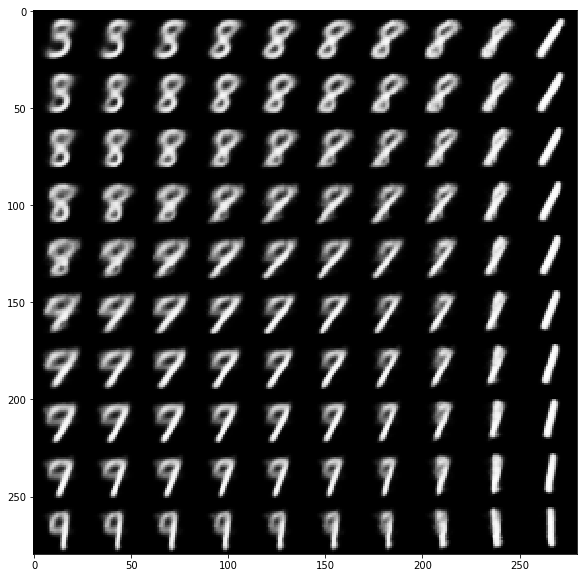

In [41]:
import matplotlib.pyplot as plt
from scipy.stats import norm
n = 10
digit_size = 28
lower_bound = 0.5
upper_bound = 99e-2
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(lower_bound, upper_bound, n))
grid_y = norm.ppf(np.linspace(lower_bound, upper_bound, n))
print( grid_x)
#print( grid_y.shape)

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()


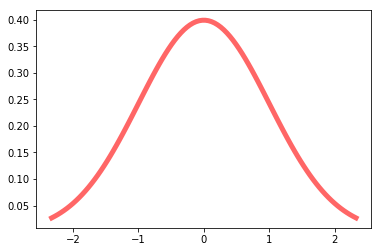

In [15]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

x = np.linspace(norm.ppf(0.01),norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),'r-', lw=5, alpha=0.6, label='norm pdf')